<div align="center" vertical-align="middle">
  <a><img height="200px" src="../../docs/scapy-logo-named-cropped.png"></a>
  <h1>Userguide for on-orbit Collision Risk evaluation</h1>
</div>



#### Table of contents
1. Environment set-up
2. Data preparation
    1. Importing events 
    2. Plot uncertainty and features evolution
    3. Get datasets for training and testing
3. Conjunction Risk evaluator model configuration
    1. Classification mode instanciation
    2. Regression mode instanciation
4. Model loading, training and saving
    1. Loading model
    2. Training model
    3. Saving model
5. Evaluating model performance using regression and classification modes
    1. Get tensor datasets for testing
    2. Classification mode
    3. Regression mode
    4. Classification vs. regression mode for conjunctions classification
6. Using classification mode to identify hazardous Conjunction Events
7. Using regression mode for collision risk probability estimation


## 1.- Environment set-up

In [1]:
# Get current working directory path for the tool parent folder and add it to the system path
from pathlib import Path
import os
foldername = 'scapy'
cwd = str(Path(os.getcwd()[:os.getcwd().index(foldername)+len(foldername)]))

# Add library path to system path if it is not included already.
import sys
if cwd not in sys.path: sys.path.append(cwd)
print(f'Current working directory: {cwd}')

# Import utils library containing miscellaneous functions/classes
from scapy import utils

# Set overall seed for reproducibility
utils.seed(1)

# Show plots in the notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
rc('text', usetex=True)


Current working directory: /Users/jjrr/Documents/SCA-Project/scapy


## 2.- Data preparation

### 2.1.- Importing events

In [2]:
from scapy import ccsds
from scapy import data
import pandas as pd

from scapy.event import ConjunctionEventsDataset as CED

# Use data from Kelvins competition:
# https://kelvins.esa.int/collision-avoidance-challenge/data/

# Download testing data from Kelvins website
_, events_test = data.get_kelvins_data(data = 'test', return_ced = True,
                                         overwrite = False, num_events = None)

# Download training data from Kelvins website
_, events_train = data.get_kelvins_data(data = 'train', return_ced = True,
                                         overwrite = False, num_events = None)



KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1726/1726)| 00h:00m:09s |  184.28   | Dataset imported (1726 events).ataset...
        

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1726/1726)| 00h:00m:27s |   62.42   | Pandas DataFrame saved.                                 

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (9586/9586)| 00h:01m:01s |  156.92   | Dataset imported (9586 events).ataset...
        

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (9586/9586)| 00h:03m:00s |   53.17   | Pandas DataFrame saved.                                 


### 2.2.- Plot uncertainty and features evolution

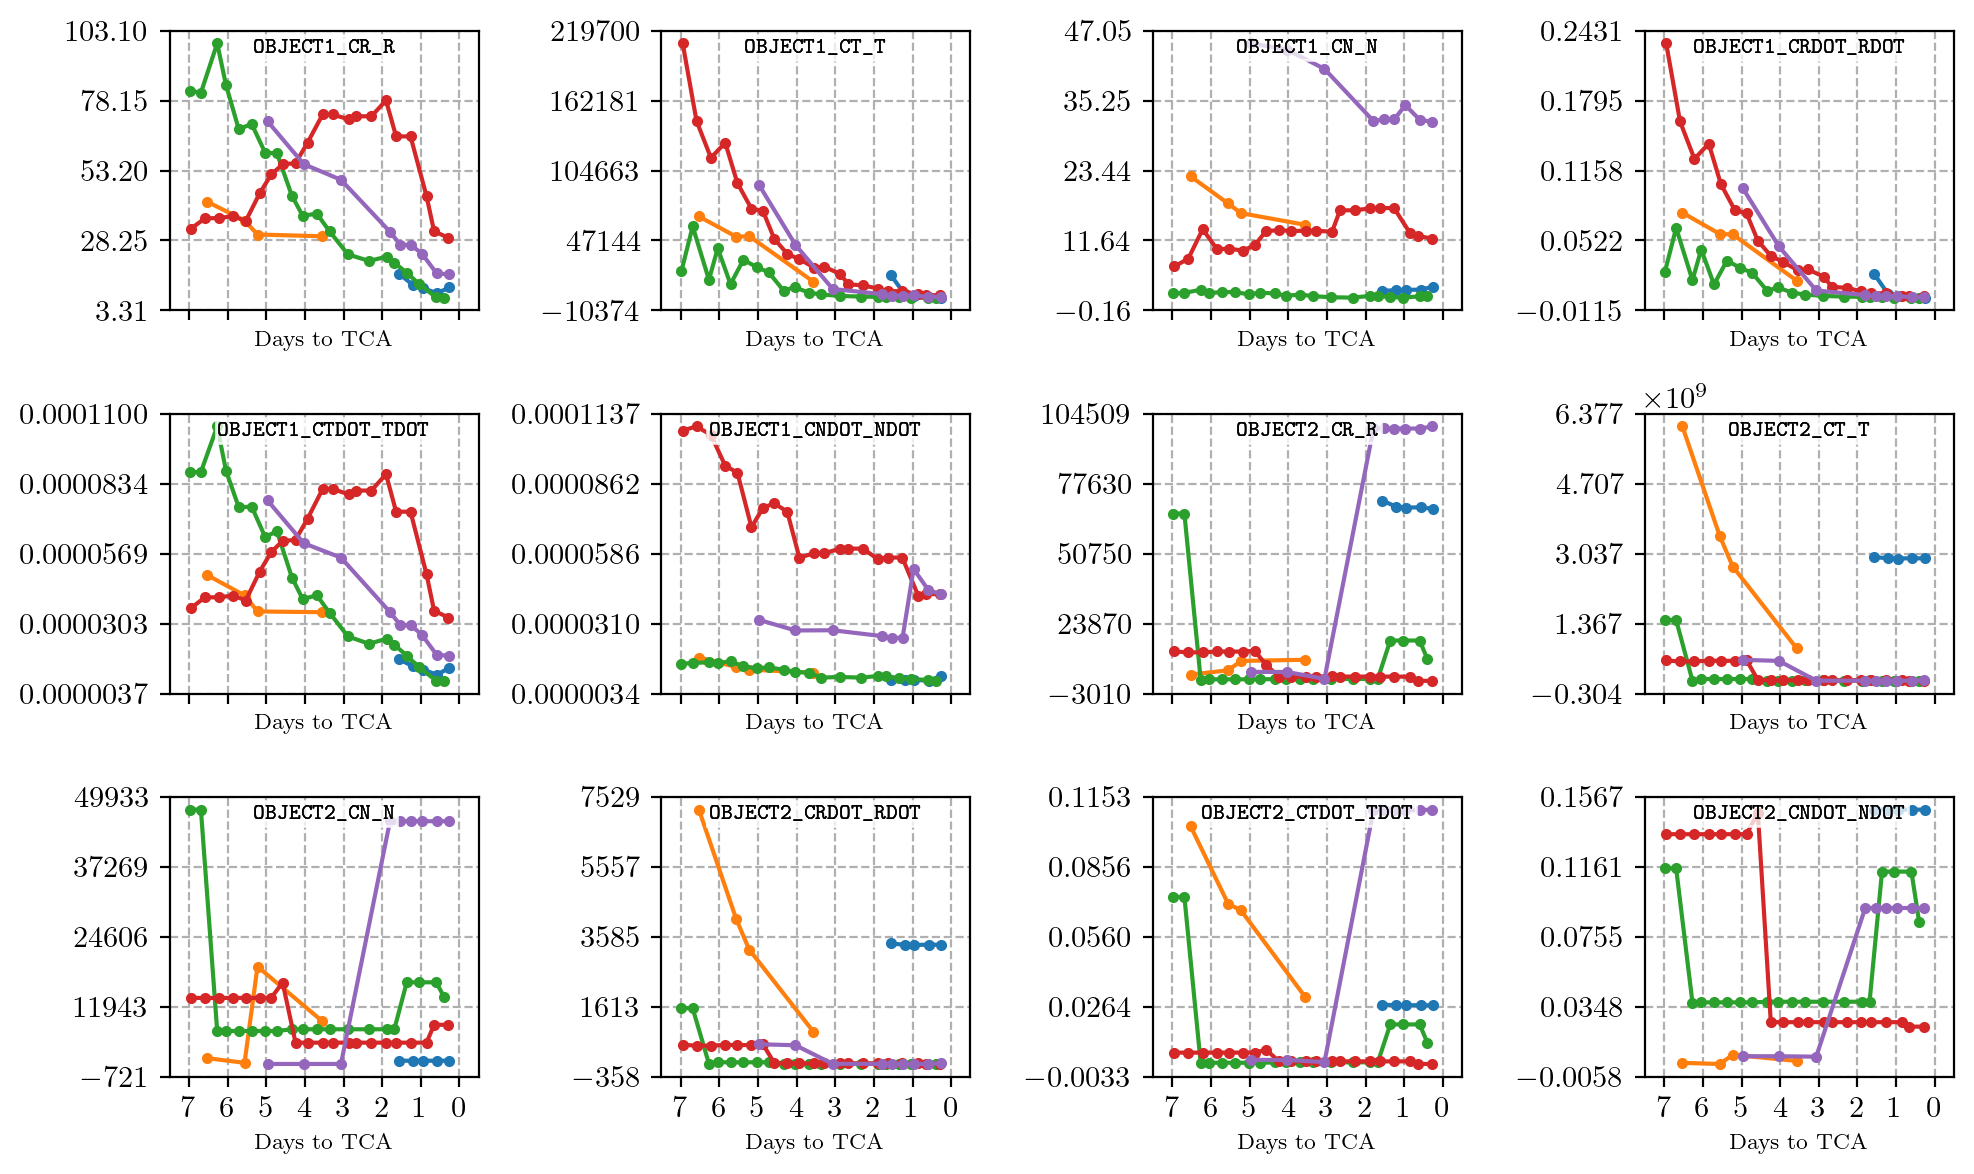

In [3]:
# Plot main diagonal of the covariance matrix
events_train[:5].plot_uncertainty(diagonal = True, figsize=(10, 6))

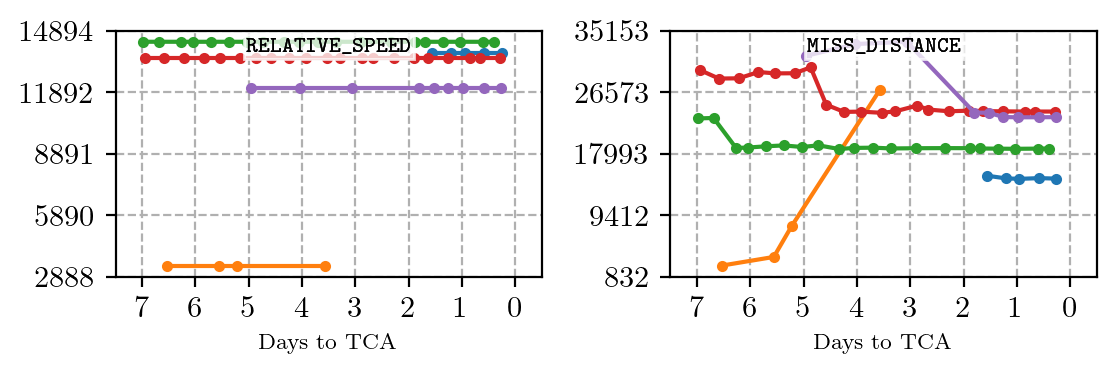

In [4]:
# Plot features evolutions
features = ['RELATIVE_SPEED', 'MISS_DISTANCE']
events_train[:5].plot_features(features = features)

### 2.3.- Get datasests for training and testing

#### Get input features and Conjunction Events for training and test as pandas DataFrame

In [7]:
# Get list of obligatory features.
input_features = ccsds.get_features(only_names=True, 
                                    include_object_preffix=True, 
                                    **dict(obligatory=True, 
                                           dtype=['int','float','category']))

# Add __DAYS_TO_TCA (float) as derived from TCA (datetime)
input_features.append('__DAYS_TO_TCA')

# Convert Conjunction Events Dataset object to dataframe and add columns
# to identify hazardous conjunctions according to the collision probability.
hazardous_threshold = -4
df_train = events_train.to_dataframe(event_id = True, 
                                hazardous_threshold = hazardous_threshold)
df_test  = events_test.to_dataframe(event_id = True, 
                                hazardous_threshold = hazardous_threshold)

# Cast all columns as the CCSDS format.
df_train = df_train.astype(ccsds.df_dtype_conversion)
df_test  = df_test.astype(ccsds.df_dtype_conversion)




CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (9586/9586)| 00h:00m:00s | 36290.95  | Pandas DataFrame saved.                                 

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1726/1726)| 00h:00m:00s | 37735.12  | Pandas DataFrame saved.                                 


#### Convert pandas DataFrames to Tensor datasets

In [8]:
# Import class to convert DataFrame to TensorDataset
from scapy.data import TensorDatasetFromDataFrame as tdfdf

# Convert pandas DataFrame to TensorDataset for training
ctd_train = tdfdf(df_input = df_train,
               input_features = input_features, 
               output_features = ['__NHC', '__PHC'])

# Convert pandas DataFrame to TensorDataset for training
rtd_train = tdfdf(df_input = df_train,
               input_features = input_features, 
               output_features = ['COLLISION_PROBABILITY'])

# Print tensor dataset objects
print(ctd_train)
print(rtd_train)

TensorDatasetFromDataFrame(Inputs: 44 | Outputs: 2 | Entries: 127037)
TensorDatasetFromDataFrame(Inputs: 44 | Outputs: 1 | Entries: 127037)


## 3.- Collision Risk Evaluator model configuration

In [38]:
from importlib import reload
import scapy.cre as cre
reload(cre)

<module 'scapy.cre' from '/Users/jjrr/Documents/SCA-Project/scapy/scapy/cre.py'>

### 3.1.- Classification  model instanciation

In [39]:
# Get classes and class_weights from the training set. This step is optional but 
# highly recommended to compensate the dataset skewness: there are many more 
# non-hazardous conjunctions than otherwise. Compensating the classification 
# weights helps the model to penalise bad predictions on hazardous conjunctions.
classes, class_weights = utils.get_class_weight(
                            data = df_train['__HAZARDOUS'].to_numpy(), 
                            class_weight = 'balanced')

print(f'Classification classes: {classes}\n'
      f'Weights: {class_weights}')

Classification classes: [False  True]
Weights: tensor([  0.5023, 108.7646])


In [40]:
# Import Collision Risk Evaluator model
from scapy.cre import CollisionRiskEvaluator as CRE
import torch.nn as nn

# Define the number of neurons per layer and number of layers for the network
layers = [200, 200, 200]

# Define activation function used. The model also accepts a list of different 
# activation functions but it shall have the same length as layers parameter.
act_functions = nn.ReLU()   

# Initialise CRE model for classification
c_model = CRE(input_size  = ctd_train.input_size,    # Set input size
              output_size = ctd_train.output_size,   # Set output size
              layers = layers,                       # Hidden neurons per layer
              act_functions = act_functions,         # Activation function(s)
              dropout_probs = 0.05,                  # Dropout probability
              )

# Set classification mode and classification mode
c_model.classification = True
c_model.class_weights = class_weights

# Print model
print(c_model)

CollisionRiskEvaluator(
  (_act_functions): ReLU()
  (model): ModuleList(
    (0): Linear(in_features=44, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=200, out_features=2, bias=True)
  )
)


### 3.2.- Regression model instanciation

In [41]:
# Define the number of neurons per layer and number of layers for the network
layers = [200, 200, 200]

# Define activation function used. The model also accepts a list of different 
# activation functions but it shall have the same length as layers parameter.
act_functions = nn.ReLU()   

# Initialise CRE model for classification
r_model = CRE(input_size  = rtd_train.input_size,    # Set input size
              output_size = rtd_train.output_size,   # Set output size
              layers = layers,                       # Hidden neurons per layer
              act_functions = act_functions,         # Activation function(s)
              dropout_probs = 0.05,                  # Dropout probability
              )

# Print model
print(r_model)

CollisionRiskEvaluator(
  (_act_functions): ReLU()
  (model): ModuleList(
    (0): Linear(in_features=44, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=200, out_features=1, bias=True)
  )
)


## 4.- Models loading and training

### 4.1.- Loading models (optional)

In [42]:
# Get model's filename where the parameters are saved
c_filename = f'cre_c_200-200-200-relu_parameters.pt'
r_filename = f'cre_r_200-200-200-relu_parameters.pt'

# Check load parameters from previous trainings:
# WARNING! This step is only valid for models instanciated with exactly the same 
#          input parameters
c_model.load(filepath = c_filename)
r_model.load(filepath = r_filename)

### 4.2.- Training models (*optional if models are already trained*)

In [20]:
# Train classification model
c_model.learn(data = ctd_train.data,        # Conjunctions for training
              epochs = 5,                   # Number of epochs
              lr = 1e-5,                    # Initial learning rate
              batch_size = 1000,            # Number of batches
              device = 'cpu',               # Tensors allocation device
              filepath = c_filename,        # Path where parameters of trained
                                            # model are saved and loaded from
              epoch_step_checkpoint = 2,    # Checkpoint epoch
              )

Number of learnable parameters of the model: 91,002

TRAINING COLLISION RISK EVALUATOR MODEL:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (540/540)| 00h:14m:24s |   0.62    | E(5/5) B(108/108) | Loss > T(3.8146e-01) V(3.6363e-01)

Saving model parameters ... Done.


In [22]:
# Train classification model
r_model.learn(data = rtd_train.data,        # Conjunctions for training
              epochs = 5,                   # Number of epochs
              lr = 1e-5,                    # Initial learning rate
              batch_size = 1000,            # Number of batches
              device = 'cpu',               # Tensors allocation device
              filepath = r_filename,        # Path where parameters of trained
                                            # model are saved and loaded from
              epoch_step_checkpoint = 2,    # Checkpoint epoch
              )

Number of learnable parameters of the model: 90,801

TRAINING COLLISION RISK EVALUATOR MODEL:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (540/540)| 00h:16m:17s |   0.55    | E(5/5) B(108/108) | Loss > T(3.5617e+01) V(3.6535e+01)

Saving model parameters ... Done.


#### Plot loss during training

Plotting to file: /Users/jjrr/Documents/SCA-Project/scapy/notebooks/users/results/cre_c_train_valid_loss.pdf
Plotting to file: /Users/jjrr/Documents/SCA-Project/scapy/notebooks/users/results/cre_r_train_valid_loss.pdf


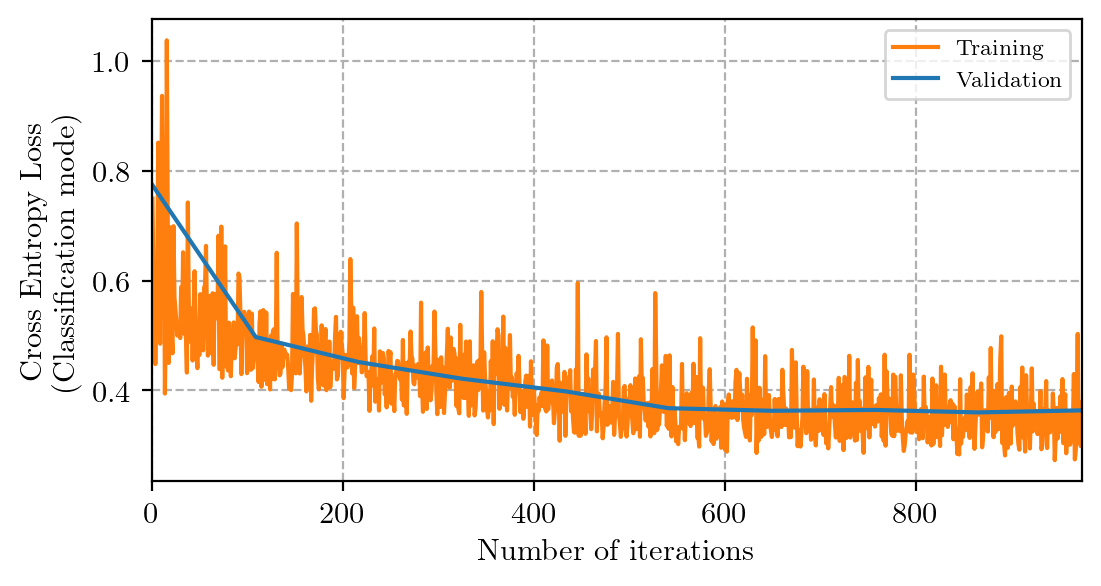

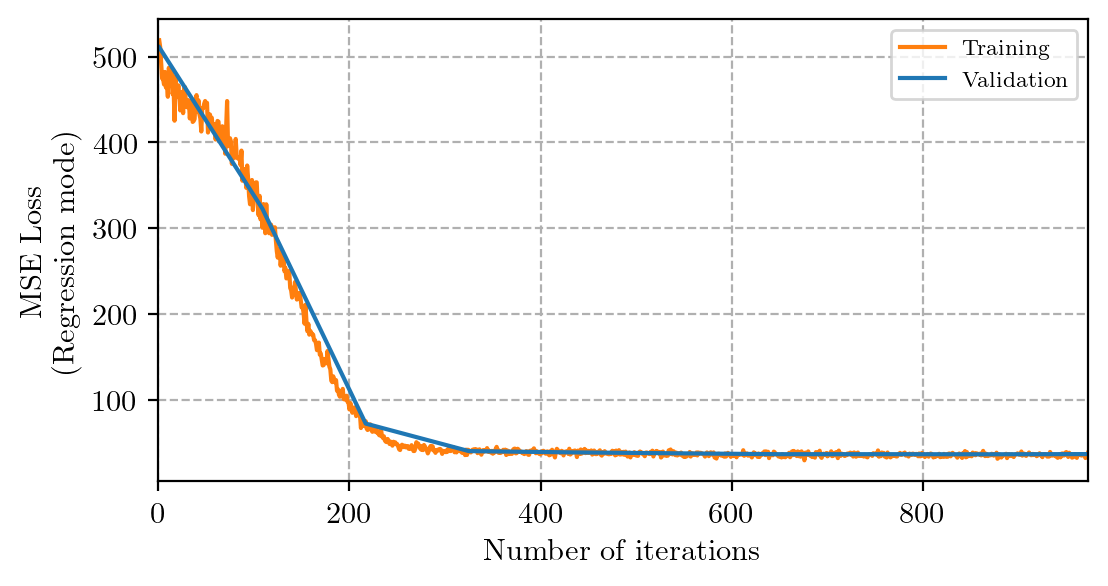

In [44]:
# Plot Cross Entropy and MSE loss for the classification and regression modes 
# respectively:
for m, model in enumerate([c_model, r_model]):
    if len(model._learn_results['total_iterations']) == 0: continue
    model.plot_loss(figsize = (6, 3),           # Figure size
                    # validation_only = True,     # Plot only validation loss
                    log_scale = False,          # Use logarithmic scale
                    plot_lr = False,             # Plot learning rate
                    filepath = os.path.join(cwd,'notebooks', 'users', 'results', 
                                        f'cre_{"cr"[m]}_train_valid_loss.pdf')
                    )

### 4.3.- Saving model (optional)

In [25]:
# Additionally, a buil-in method can be used to save the model
c_model.save(filepath = c_filename,   # Path where parameters are saved (.pt)
             only_parameters = True   # Save only parameters.
             )

r_model.save(filepath = r_filename,   # Path where parameters are saved (.pt)
             only_parameters = True   # Save only parameters.
             )

## 5.- Evaluating model performance using regression and classification modes on the test dataset

### 5.1.- Get tensor datasets for testing

In [26]:
# Convert pandas DataFrame to TensorDataset for training
ctd_test = tdfdf(df_input = df_test,
               input_features = input_features, 
               output_features = ['__NHC', '__PHC'])

# Convert pandas DataFrame to TensorDataset for training
rtd_test = tdfdf(df_input = df_test,
               input_features = input_features, 
               output_features = ['COLLISION_PROBABILITY'])

print(f'Classification: {ctd_test}')
print(f'Regression:     {rtd_test}')

Classification: TensorDatasetFromDataFrame(Inputs: 44 | Outputs: 2 | Entries: 19531)
Regression:     TensorDatasetFromDataFrame(Inputs: 44 | Outputs: 1 | Entries: 19531)


### 5.2.- Classification mode

In [27]:
# Test model using the test dataset.
# - Confusion matrix    (TP, FP, FN, TN)
# - Accuracy            = (TP + TN) / (TP + FP + FN + TN)
# - Recall              = TP / (TP + FN)
# - Precision           = TP / (TP + FP)
# - F1-Score            = 2 * (Recall * Precision) / (Recall + Precision)
# - AUC-ROC             (Area under the ROC)

# Predict multiple times 
cla_results = pd.DataFrame()
for s in range(100):
    utils.seed(s)
    s_results = c_model.test(data = ctd_test.data,   # List of events for test
                             as_dataframe = True     # Results as DataFrame
                             )

    cla_results = pd.concat([cla_results, s_results], 
                            ignore_index=True)

In [28]:
# Display test performance scores
cla_results_summary = cla_results.describe().loc[['mean','std']]

display(cla_results_summary.T)

,mean,std
tp,129.430000,3.545534
fn,70.570000,3.545534
fp,4415.780000,26.754998
tn,14915.220000,26.754998
accuracy,0.770296,0.001362
precision,0.028476,0.000758
recall,0.647150,0.017728
f1,0.054552,0.001452
aucroc,0.709360,0.008814


### 5.3.- Regression mode

In [29]:
# Test model using the events_test dataset.
# - SSE     (Sum of Squared Errors)     
# - MSE     (Mean Squared Errors)
# - MAE     (Mean Absolute Errors)     
# - MAPE    (Mean Absolute Percentage Errors)
# - BIC     (Bayesian Information Criterion)

reg_results = r_model.test(data = rtd_test.data,  # List of events for test
                          test_batch_size = 100,       # Number of batches
                          as_dataframe = True         # Results as DataFrame
                          )

In [30]:
# Display test performance scores
display(reg_results.head(5))

# Display statistics from test performance scores
display(reg_results.describe().round(decimals=4))

,sse,mse,mae,mape,bic
0,7305.498047,73.054977,6.546857,70.198380,418583.179285
1,8691.273438,86.912735,6.747053,81.725365,418600.548515
2,6924.732910,69.247330,5.970195,50.451881,418577.826516
3,5832.461426,58.324615,5.109370,46.790600,418560.660480
4,4642.316406,46.423164,5.102404,43.302032,418537.837915


,sse,mse,mae,mape,bic
count,196.0000,196.0000,196.0000,196.0000,196.0000
mean,7292.0399,73.1581,6.2221,67.2657,418037.5012
std,1421.4142,13.7213,0.6471,11.0417,7617.2755
min,2093.5085,42.5186,4.7320,40.5098,311940.0630
25%,6306.7546,63.1003,5.7804,60.3295,418568.4787
50%,7236.2451,72.3625,6.1931,67.4287,418582.2268
75%,8144.0438,81.4404,6.6860,74.5228,418594.0452
max,11169.7607,111.6976,8.0244,95.1577,418625.6376


#### Using regression mode for classification

In [31]:
from sklearn.metrics import roc_auc_score as auc_roc
from importlib import reload
reload(utils)

# Get the collision risk probabilities from the model and the test dataset
r_test_data = rtd_test.data

y_true = (r_test_data.outputs.detach().numpy().flatten()) >= hazardous_threshold

# Initialise dataframe to store classification metrics using the regression mode
reg_results_class = pd.DataFrame()

for s in range(10):
      utils.seed(s)

      # Get predictions
      y_pred = r_model.forward(r_test_data.inputs).detach().numpy().flatten()

      # Evaluate accuracy using the confusion matrix.
      y_pred = y_pred >= hazardous_threshold

      # Get the values from the confusion matrix.
      s_metrics = utils.binary_confusion_matrix(y_pred, y_true)

      try:
            s_metrics['aucroc'] = auc_roc(y_true, y_pred)
      except:
            s_metrics['aucroc'] = 0

      # Convert values to list of values
      s_metrics = {k:[v] for k, v in s_metrics.items()}

      # Convert dictionary to dataframe
      s_metrics = pd.DataFrame.from_dict(data = s_metrics, orient='columns')

      reg_results_class = pd.concat([reg_results_class, s_metrics], \
                                     ignore_index = True)

# Display test performance scores
reg_results_class = reg_results_class[cla_results.columns]
reg_results_class_summary = reg_results_class.describe().loc[['mean','std']]

display(reg_results_class_summary.T)


,mean,std
tp,0.300000,0.674949
fn,199.700000,0.674949
fp,45.800000,4.184628
tn,19285.200000,4.184628
accuracy,0.987430,0.000207
precision,0.006136,0.013211
recall,0.001500,0.003375
f1,0.002402,0.005352
aucroc,0.499565,0.001658


### 5.4.- Comparing regression and classification modes for hazardous Conjunction identification

In [32]:
modes_results = {'classification':  cla_results_summary.loc['mean'],
                 'regression':  reg_results_class_summary.loc['mean']}

for mode, mode_results in modes_results.items():
      
      print(f'\nMODE: {mode.upper()}')
      tp, fn, fp, tn = mode_results[['tp', 'fn', 'fp', 'tn']].round(decimals=0)
      utils.normalise_cfm(tp = tp, fp = fp, fn = fn, tn = tn, 
                  normalize='cols', print_cf=True)


MODE: CLASSIFICATION
Confusion matrix normalised:
TP: 64.5% (129.0)    FP: 22.8% (4416.0)  
FN: 35.5% (71.0)     TN: 77.2% (14915.0) 

MODE: REGRESSION
Confusion matrix normalised:
TP:  0.0% (0.0)      FP:  0.2% (46.0)    
FN: 100.0% (200.0)    TN: 99.8% (19285.0) 


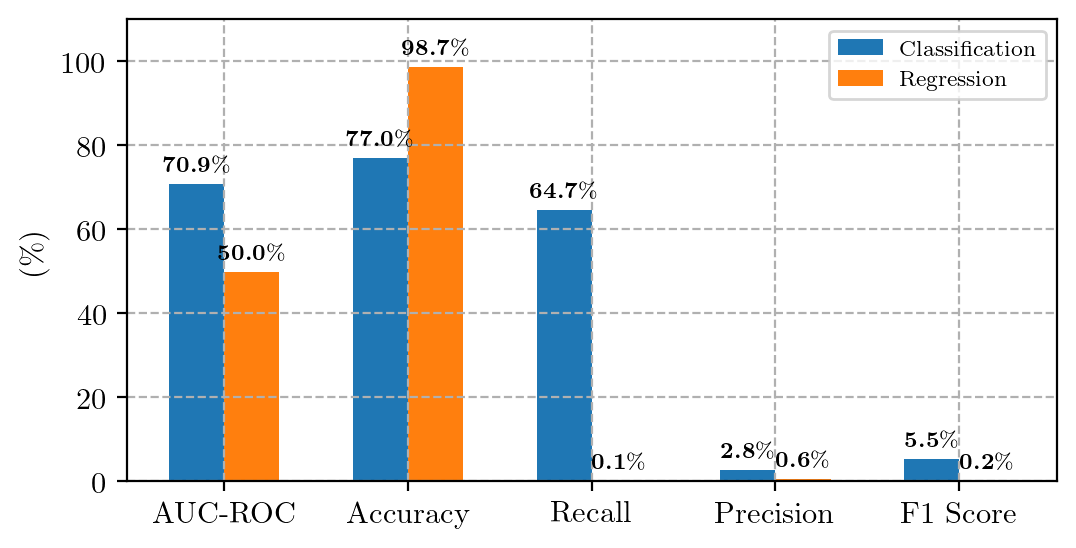

In [33]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

metrics = ["aucroc", "accuracy", "recall", "precision", "f1"]
labels = ["AUC-ROC", "Accuracy", "Recall", "Precision", "F1 Score"]

modes_results = {'classification': modes_results['classification'][metrics]*100,
                 'regression':  modes_results['regression'][metrics]*100}

x = np.arange(len(metrics))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize = (6,3))

for i, (mode, values) in enumerate(modes_results.items()):

    # Plot vertical bars
    rects = ax.bar(x + width * i, values, width, label = mode.capitalize())

    # Plot data labels 
    bar_labels = ['\\textbf{' + f"{v:.1f}" + '}\%' for v in values]
    ax.bar_label(rects, padding=3, labels = bar_labels, fontsize=8)

# Customize X-axis ticks
ax.set_xticks(x + width/2, labels)
# Configure Y-axis parameters
ax.set_ylabel('(\%)')
ax.set_ylim(0, 110)

ax.legend(loc='upper right', fontsize=8)
ax.grid(True, linestyle='--')
plt.savefig(os.path.join(utils.cwd,'notebooks', 'devs', 'results', 
                         'cre_classification_vs_regression.pdf'), 
               bbox_inches='tight')
plt.show()

## 6.- Using CRE classification mode to identify hazardous Conjunction Events.

In [ ]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
forecasts = model.predict_event(event = event_beginning, 
                                num_samples = 10, 
                                max_length = 14
                                )

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CR_R', 'OBJECT1_CT_T']

# Set keyword arguments for the plots
kwargs = dict(linewidth = 0.1, color= 'red', alpha = 0.33, label = 'Prediction')

# Plot forecasted values of features
axs_pred = forecasts.plot_features(features = features,
                                   figsize = (6, 4), 
                                   return_axs = True,
                                   row_subplots = 2,
                                   **kwargs
                                   )
# Plot true values of features in blue:
event.plot_features(features = features, 
                    axs = axs_pred, 
                    label = 'Actual', 
                    legend = True)

## 7.- Using CRE regression mode to estimate Collision Risk probability